In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (f1_score, accuracy_score, confusion_matrix, 
                             classification_report, ConfusionMatrixDisplay)

In [76]:
# Fix the dataframe creation order
df = pd.read_csv("synthetic_access_data_10000.csv")
df.head()

,request_id,timestamp,user_id,user_role,department,employee_status,resource_type,resource_sensitivity,action,request_reason,time_in_position,location,device_type,ip_address,last_security_training,employee_join_date,region,encryption_required,past_violations,is_approved
0,589222,2022-06-04T22:06:05.383695,2938,Manager,IT,Full-time,doc,confidential,delete,Routine check,4 years,HQ - London,Server,215.191.157.76,2023-09-29,2023-05-06,LATAM,Yes,0,1
1,945503,2020-07-24T01:44:27.915343,4016,Contractor,Operations,Part-time,doc,restricted,download,Client request,6 months,VPN - US,Mobile,212.178.71.52,Never,2018-06-23,NaN,Yes,0,1
2,774588,2023-01-10T18:42:53.291069,1457,Manager,Operations,Contract,spreadsheet,public,read,Routine check,3 years,Tokyo Office,Desktop,159.4.26.152,2024-05-26,2021-08-03,LATAM,No,3,0
3,863083,2021-07-24T14:14:40.579194,8507,Intern,Finance,Contract,video,public,download,Audit,5 years,Tokyo Office,Server,26.30.167.49,Never,2015-09-07,APAC,No,1,1
4,808774,2025-03-04T23:07:35.878265,2570,Intern,Legal,Terminated,spreadsheet,restricted,edit,Personal use,5 years,Remote - Brazil,Desktop,68.15.13.178,2025-01-27,2022-03-18,APAC,No,5,0


In [77]:
# Convert time in position first
def convert_to_months(value):
    value = str(value).lower()
    if 'year' in value:
        return int(value.split()[0]) * 12
    elif 'month' in value:
        return int(value.split()[0])
    else:
        return 0

In [78]:
df['time_in_position_months'] = df['time_in_position'].apply(convert_to_months)


# Rest of preprocessing remains the same
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp_minutes'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute
required_cols = ['user_role', 'department', 'employee_status', 'resource_type',
                'resource_sensitivity', 'action', 'request_reason', 'time_in_position_months',
                'timestamp_minutes', 'location', 'device_type', 'region',
                'past_violations','encryption_required', 'is_approved']
df = df[required_cols]
df = df.dropna(subset=required_cols)


df.head()

,user_role,department,employee_status,resource_type,resource_sensitivity,action,request_reason,time_in_position_months,timestamp_minutes,location,device_type,region,past_violations,encryption_required,is_approved
0,Manager,IT,Full-time,doc,confidential,delete,Routine check,48,1326.0,HQ - London,Server,LATAM,0,Yes,1
2,Manager,Operations,Contract,spreadsheet,public,read,Routine check,36,1122.0,Tokyo Office,Desktop,LATAM,3,No,0
3,Intern,Finance,Contract,video,public,download,Audit,60,854.0,Tokyo Office,Server,APAC,1,No,1
4,Intern,Legal,Terminated,spreadsheet,restricted,edit,Personal use,60,1387.0,Remote - Brazil,Desktop,APAC,5,No,0
5,Intern,Sales,Contract,presentation,restricted,download,Personal use,1,951.0,Remote - Brazil,Mobile,LATAM,5,No,0


In [79]:

# Feature engineering

features = ['user_role', 'department', 'employee_status', 'resource_type',
            'resource_sensitivity', 'action', 'request_reason', 'time_in_position_months',
            'timestamp_minutes', 'location', 'device_type', 'region', 'encryption_required', 'past_violations']
X = df[features]
y = df['is_approved']

# Label encoding
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

C:\Users\yugtg\AppData\Local\Temp\ipykernel_16812\1803647274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\yugtg\AppData\Local\Temp\ipykernel_16812\1803647274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\yugtg\AppData\Local\Temp\ipykernel_16812\1803647274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [80]:
# Enhanced feature engineering
X['high_risk_action'] = X['action'].isin(label_encoders['action'].transform(['delete', 'download'])).astype(int)
X['high_sensitivity'] = X['resource_sensitivity'].isin(label_encoders['resource_sensitivity'].transform(['confidential', 'restricted'])).astype(int)
X['vpn_access'] = X['location'].isin(label_encoders['location'].transform(['VPN - US'])).astype(int)
X['long_term_employee'] = (X['time_in_position_months'] > 36).astype(int)

In [81]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [82]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}


In [83]:
# Store metrics and reports
results = []
classification_reports = {}
confusion_matrices = {}
feature_importances = {}

<Figure size 1500x1000 with 0 Axes>

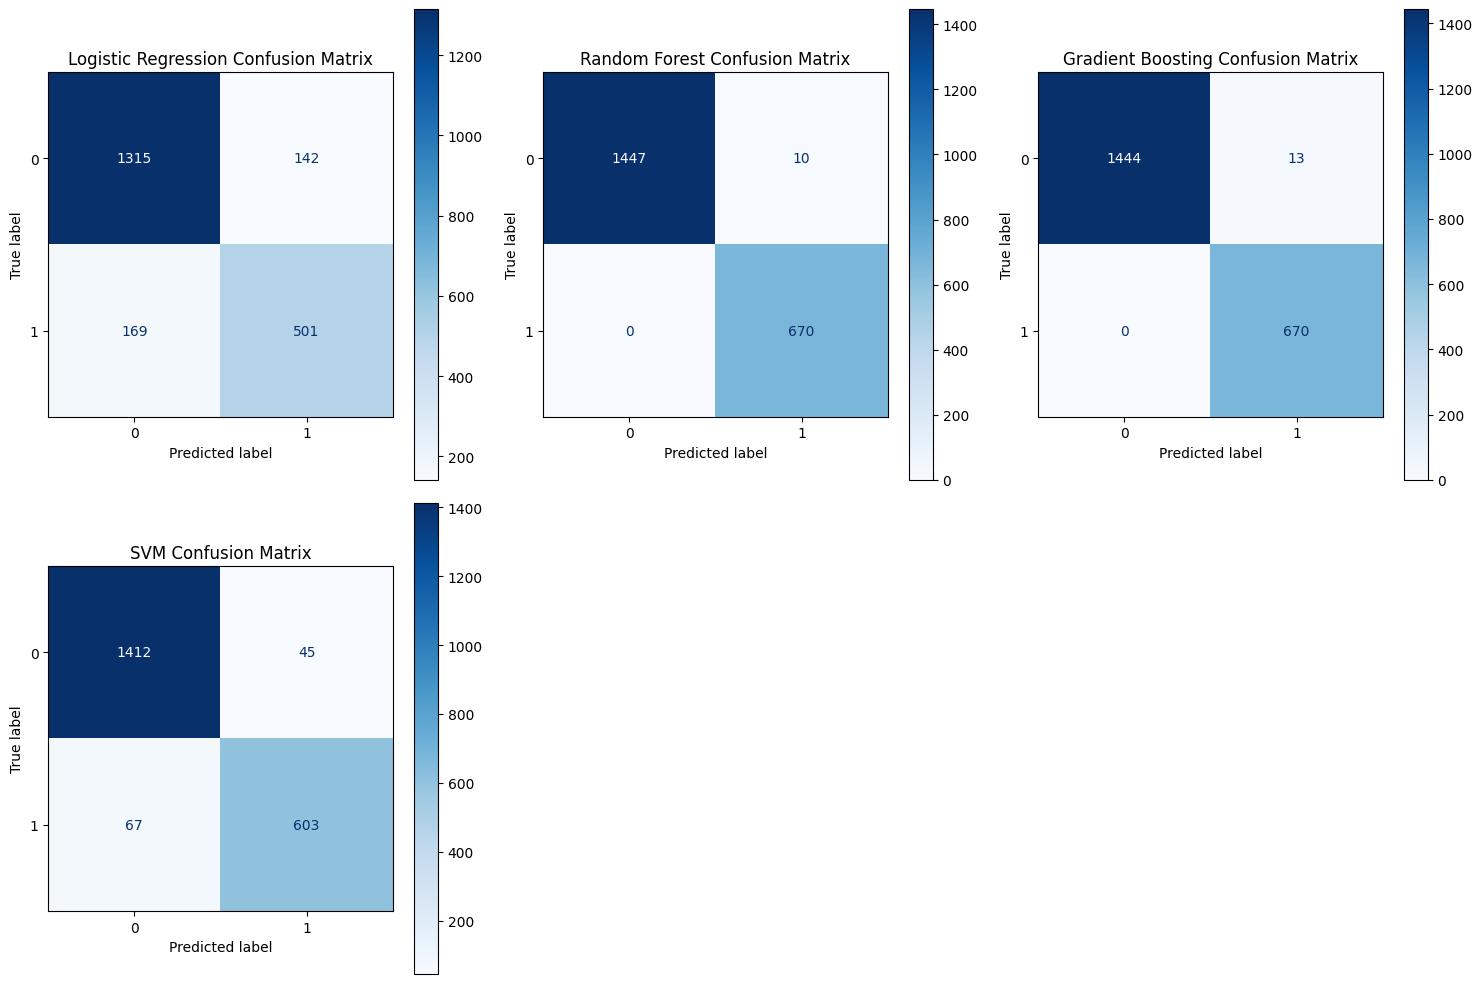

In [84]:
plt.figure(figsize=(15, 10))
n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols  # Proper row calculation

# Create ALL subplots in the grid first
axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))[1].flatten()

for i, (name, model) in enumerate(models.items()):
    # Train model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')

# Hide unused subplots
for j in range(n_models, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

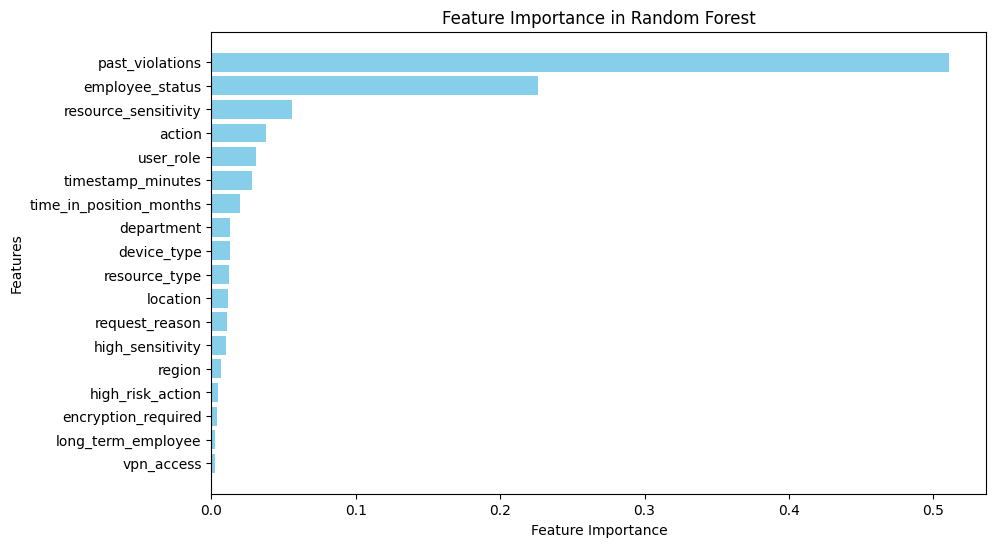

In [85]:
# Corrected Feature Importance Visualization for Random Forest
plt.figure(figsize=(10, 6))

# Fit the Random Forest model
rf_model = models["Random Forest"]
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Use the correct feature names from the DataFrame
feature_names = X.columns  # Ensure this matches the processed DataFrame
features_sorted = [feature_names[i] for i in indices]

# Plot the feature importances
plt.barh(features_sorted, importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [86]:
# Compare models based on accuracy and F1 score
comparison_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    comparison_results.append({"Model": name, "Accuracy": accuracy, "F1 Score": f1})

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)



                 Model  Accuracy  F1 Score
0  Logistic Regression  0.853785  0.763138
1        Random Forest  0.992948  0.988930
2    Gradient Boosting  0.993888  0.990392
3                  SVM  0.947344  0.915023


In [87]:
# Display classification report for Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1457
           1       0.98      1.00      0.99       670

    accuracy                           0.99      2127
   macro avg       0.99      0.99      0.99      2127
weighted avg       0.99      0.99      0.99      2127



In [88]:
import pickle

# Save the Random Forest model
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)
print("Random Forest model saved as 'random_forest_model.pkl'")

Random Forest model saved as 'random_forest_model.pkl'


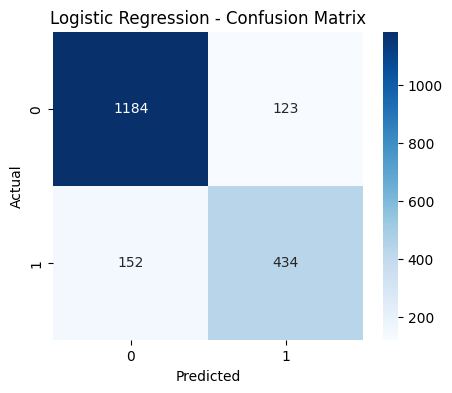

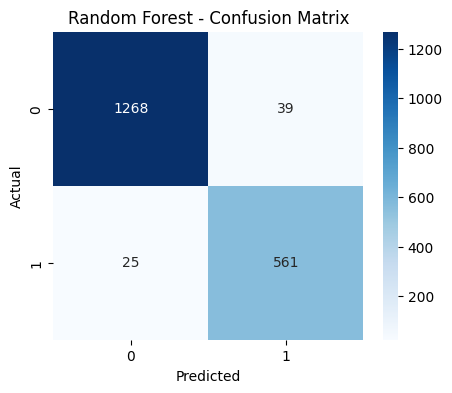

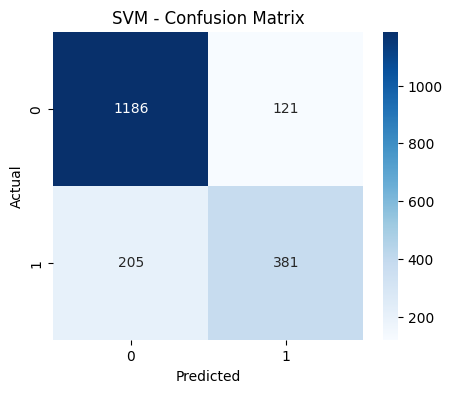

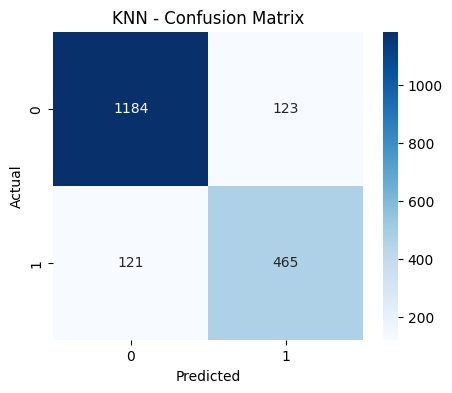


Model Accuracies:
Logistic Regression: 0.8547
Random Forest: 0.9662
SVM: 0.8278
KNN: 0.8711


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load the dataset
data = pd.read_csv('synthetic_access_data_10000.csv')

# Select only the needed columns
columns_to_use = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity', 'employee_join_date', 'past_violations', 'is_approved']
data = data[columns_to_use]

# Drop rows with missing values
data.dropna(inplace=True)

# Feature engineering: derive time spent in months
current_date = pd.to_datetime('today')
data['employee_join_date'] = pd.to_datetime(data['employee_join_date'], errors='coerce')
data.dropna(subset=['employee_join_date'], inplace=True)
data['time_spent_months'] = (current_date - data['employee_join_date']).dt.days // 30

# Drop the original 'employee_join_date'
data.drop('employee_join_date', axis=1, inplace=True)

label_encoders = {}
categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Fit on original strings
    label_encoders[col] = le  # Save the encoder

    
# Define features and target
X = data.drop('is_approved', axis=1)
y = data['is_approved']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

accuracies = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print all accuracies
print("\nModel Accuracies:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")


In [120]:
# import pickle

# # Save the Random Forest model
# with open('random_forest_model_new.pkl', 'wb') as file:
#     pickle.dump(models['Random Forest'], file)

In [122]:
# Save the model and encoders
with open('random_forest_model_new.pkl', 'wb') as model_file:
    pickle.dump(models['Random Forest'], model_file)

with open('label_encoders.pkl', 'wb') as encoders_file:
    pickle.dump(label_encoders, encoders_file)

In [123]:
# import pickle
# from sklearn.preprocessing import LabelEncoder

# # Encode categorical variables and save encoders
# label_encoders = {}
# categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
# for col in categorical_cols:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le  # Save the encoder for this column

# # Save the Random Forest model and label encoders
# with open('random_forest_model_new.pkl', 'wb') as model_file:
#     pickle.dump(models['Random Forest'], model_file)

# with open('label_encoders.pkl', 'wb') as encoders_file:
#     pickle.dump(label_encoders, encoders_file)

In [130]:
#FINALLL MODELLLL PREDICTIONNNN


import pickle
import pandas as pd
from datetime import datetime

# Load the saved Random Forest model and label encoders
with open('random_forest_model_new.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('label_encoders.pkl', 'rb') as encoders_file:
    label_encoders = pickle.load(encoders_file)

# Dummy data for a single user
user_data = {
    'user_role': 'Admin',
    'department': 'IT',
    'employee_status': 'Terminated',
    'resource_type': 'doc',
    'resource_sensitivity': 'restricted',
    'employee_join_date': '02-04-2020',
    'past_violations': 0
}

# Convert to DataFrame
user_df = pd.DataFrame([user_data])

# Preprocess the data (use saved encoders for consistency)
categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
for col in categorical_cols:
    le = label_encoders[col]
    # Handle unseen categories if necessary
    if user_df[col].iloc[0] not in le.classes_:
        # Option 1: Assign a default value (e.g., 'Unknown')
        # Option 2: Raise an error or handle as needed
        user_df[col] = 'Unknown'  # Example handling
    user_df[col] = le.transform(user_df[col])

# Feature engineering: derive time spent in months
current_date = pd.to_datetime('today')
user_df['employee_join_date'] = pd.to_datetime(user_df['employee_join_date'], errors='coerce')
user_df['time_spent_months'] = (current_date - user_df['employee_join_date']).dt.days // 30

# Drop the original 'employee_join_date'
user_df.drop('employee_join_date', axis=1, inplace=True)

# Predict using the Random Forest model
prediction = model.predict(user_df)
probability = model.predict_proba(user_df)

# Output the result
print(f"Prediction: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
print(f"Probability: {probability[0]}")

Prediction: Not Approved
Probability: [0.99 0.01]


In [103]:
# import pickle
# import pandas as pd
# from datetime import datetime

# # Load the saved Random Forest model
# with open('random_forest_model_new.pkl', 'rb') as file:
#     random_forest_model = pickle.load(file)

# # Dummy data for a single user
# user_data = {
#     'user_role': 'Admin',
#     'department': 'Finance',
#     'employee_status': 'Active',
#     'resource_type': 'spreadsheet',
#     'resource_sensitivity': 'Restricted',
#     'employee_join_date': '02-04-2020',
#     'past_violations': 2
# }

# # Convert to DataFrame"
# user_df = pd.DataFrame([user_data])

# # Preprocess the data (same steps as in training)
# categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
# label_encoders = {}

# # Load the label encoders used during training
# for col in categorical_cols:
#     le = LabelEncoder()
#     user_df[col] = le.fit_transform(user_df[col])  # Ensure consistency with training

# # Feature engineering: derive time spent in months
# current_date = pd.to_datetime('today')
# user_df['employee_join_date'] = pd.to_datetime(user_df['employee_join_date'], errors='coerce')
# user_df['time_spent_months'] = (current_date - user_df['employee_join_date']).dt.days // 30

# # Drop the original 'employee_join_date'
# user_df.drop('employee_join_date', axis=1, inplace=True)

# # Predict using the Random Forest model
# prediction = random_forest_model.predict(user_df)
# probability = random_forest_model.predict_proba(user_df)

# # Output the result
# print(f"Prediction: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
# print(f"Probability: {probability[0]}")